In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np

(tutorials:advanced_atomic_models)=
# Advanced atomic models

In this advanced tutorial, we cover more complex ways of creating and manipulating atomic models.

## Downloading structures from databases
You can obtain structure files for most crystal structures from internet databases through your browser. The structure file imported above was downloaded from the [Materials Project](https://materialsproject.org/), but note that you need a free account to download data. We recommend this database because it is open source and provides a huge number of high-quality structures. It should howdever be noted that structures in the Materials Project database are determined computationally, and hence they may differ slightly from experiment. 

The simplest way to get a structure from the Materials Project is to find it through their web interface, but you can also access their database through an API. Below we use the API to obtain the same strontium titanate structure. To run this code, you need an API key from the materials project and insert it in place of "your_api_key". In the example below, which is shown but not excuted, we additionally use the [pymatgen](https://pymatgen.org/) package to adapt the structure into the ASE format.

```python
from mp_api.client import MPRester
from pymatgen.io.ase import AseAtomsAdaptor

with MPRester("your_api_key") as mpr:
    docs = mpr.summary.search(material_ids=["mp-5229"], fields=["structure"])
    srtio3 = AseAtomsAdaptor().get_atoms(docs[0].structure)
```

## Visualizing structures in 3D

To view the atoms in an interactive 3D graphical user interface (GUI) viewer, we can use ASE's `view` function (see the documentation [here](https://wiki.fysik.dtu.dk/ase/ase/visualize/visualize.html)). Note that this may not work in a remote environment unless X11 forwarding is correctly set up (below we simply show the code instead of running it).
```python
from ase.visualize import view
view(srtio3)
```

If you are working in a remote environment or prefer to embed the 3D viewer in the notebook, you need to install [nglview](https://github.com/nglviewer/nglview) (which is not a default dependency of *ab*TEM). This will allow you to use the nglview backend for the `view` function.
```python
view(srtio3, viewer='nglview')
```

## Building structures

In addition to importing structures, ASE has tools for procedurally creating many common structures:

* Common bulk crystals: [`ase.build.bulk`](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#ase.build.bulk)
* Bulk structures by its spacegroup: [`ase.spacegroup.crystal`](https://wiki.fysik.dtu.dk/ase/ase/spacegroup/spacegroup.html?highlight=crystal)
* Carbon nanotubes: [`ase.build.nanotube`](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#nanotubes)
* Nanoparticles: [`ase.cluster`](https://wiki.fysik.dtu.dk/ase/ase/cluster/cluster.html)

As an example, we create a nanoparticle of gold by specifying 6 layers in the (100) directions, 9 in the (110) directions and 5 in the (111) directions.

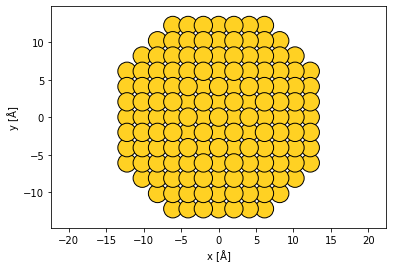

In [2]:
from ase.cluster import FaceCenteredCubic

surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [6, 9, 5]
lc = 4.08

nanoparticle = FaceCenteredCubic(
    "Au", surfaces, layers, latticeconstant=lc
)

abtem.show_atoms(nanoparticle, scale=0.9);

## Manipulating structures

The structure you import or build may not match your requirements or the requirements of *ab*TEM. Here, we exemplify the most common manipulations needed to modify atomic models for image simulation.

### Rotating structures
A common problem when creating model structures is choosing the imaging direction. *ab*TEM always assumes that the imaging electrons travel along the $z$-axis in the direction from negative to positive coordinate values, hence choosing the propagation direction requires manipulating the atomic structure.

In this example, we rotate the nanoparticle into the (111) zone axis. We first [`rotate`](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#ase.Atoms.rotate) the atoms by 45&deg; around $x$ and then by $\sim$35.26&deg; around $y$.

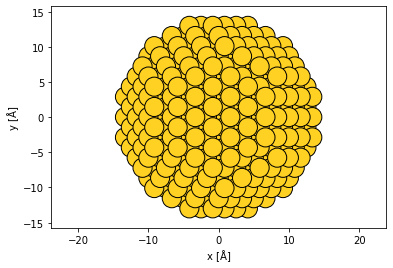

In [3]:
rotated_nanoparticle = nanoparticle.copy()

rotated_nanoparticle.rotate(45, "x")

y_angle = np.degrees(np.arctan(1 / np.sqrt(2)))
rotated_nanoparticle.rotate(y_angle, "y")

abtem.show_atoms(rotated_nanoparticle, scale=1);

### Adding vacuum

The unit cell of the nanoparticle has *zero extent*.

In [4]:
rotated_nanoparticle.cell

Cell([0.0, 0.0, 0.0])

The extent of the unit cell determines the extent of the wave function, hence this is an **invalid** cell for abTEM simulations. We can use the `center` method to add vacuum around the unit cell.

In [5]:
centered_nanoparticle = rotated_nanoparticle.copy()

centered_nanoparticle.center(vacuum=2)

Showing the structure, we now see that there is a vacuum of $2 \ \mathrm{Å}$ separating the outermost atoms and the unit cell boundary (shown as thick black lines).   

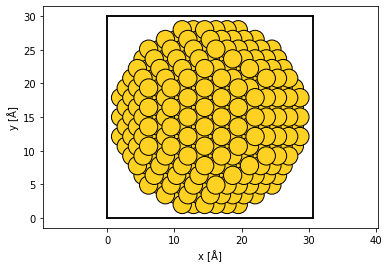

In [6]:
abtem.show_atoms(centered_nanoparticle, scale=1);

### Rotation of bulk structures

We simply rotated the nanoparticle without considering the unit cell because it does not require periodicity at the cell boundary. This is not possible for periodic structures; in such cases ASE provides the [`surface`](https://wiki.fysik.dtu.dk/ase/ase/build/surface.html#create-specific-non-common-surfaces) function for picking the [zone axis](https://en.wikipedia.org/wiki/Zone_axis) of a given structure by providing the Miller indices. Below we create a SrTiO<sub>3</sub> structure in the (110) zone axis.

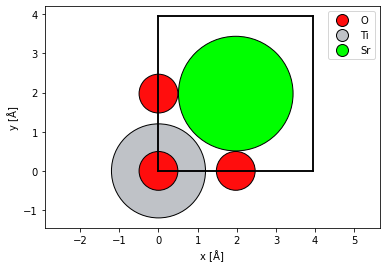

In [32]:
abtem.show_atoms(srtio3, legend=True);

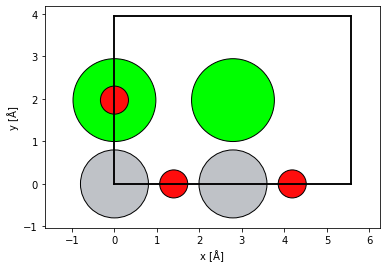

In [35]:
srtio3 = ase.io.read("../walkthrough/data/SrTiO3.cif")

srtio3_110 = ase.build.surface(srtio3, 
                               indices=(1, 1, 0), 
                               layers=2, 
                               periodic=True)

srtio3_110.translate((0,srtio3_110.cell.lengths()[1] / 2,0))

srtio3_110.wrap()

abtem.show_atoms(srtio3_110, plane="xy", scale=0.5);

```{seealso}
For creating a view that does not correspond to a low-index zone axis, see [our introduction to creating arbitrary orthogonal structures](tutorials:advanced_atomic_models:orthogonal) at the bottom of this document.
```

### Conditionally modifying atoms

The atomic positions and numbers are just `numpy` arrays and can be modified directly. The ASE documentation provides some tips [here](https://wiki.fysik.dtu.dk/ase/tips.html#atoms-objects).

We create a SrTiO<sub>3</sub> / LaTiO<sub>3</sub> interface by changing the atomic number of the Sr atoms in one half of the cell.

In [23]:
repeated_srtio3.translate?

Signature: repeated_srtio3.translate(displacement)
Docstring:
Translate atomic positions.

The displacement argument can be a float an xyz vector or an
nx3 array (where n is the number of atoms).
File:      c:\users\jacob\anaconda3\envs\abtem-dask\lib\site-packages\ase\atoms.py
Type:      method


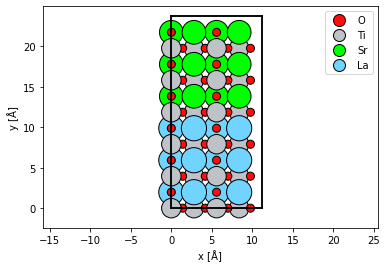

In [38]:
repeated_srtio3 = srtio3_110 * (2, 6, 4)

sto_lto_interface = repeated_srtio3.copy()

# select atoms with atomic number 38
mask_sr = sto_lto_interface.numbers == 38

# select atoms below the center
mask_below = sto_lto_interface.positions[:, 1] < sto_lto_interface.cell[1, 1] / 2

# combine selection
mask_combined = mask_sr * mask_below

# assign new atomic numbers to selection
sto_lto_interface.numbers[mask_combined] = 57

ase.io.write("./data/STO_LTO.cif", sto_lto_interface)

abtem.show_atoms(sto_lto_interface, legend=True);

### Scaling structures

The structure created above uses the lattice constant of SrTiO<sub>3</sub> calculated from DFT. Below we scale the structure to have the average experimental lattice constant of SrTiO<sub>3</sub> and LaTiO<sub>3</sub>, achieved by using the `scale_atoms=True` parameter.

In [9]:
scaled_sto_lto_interface = sto_lto_interface.copy()

a_sr = 3.905
a_la = 3.97
a_new = (3.905 + 3.97) / 2
a_old = srtio3.cell[0, 0]

new_cell = sto_lto_interface.cell * (a_new / a_old)

scaled_sto_lto_interface.set_cell(new_cell, scale_atoms=True)

```{note}
We modified the STO/LTO interface above without any regard to the atomic-scale physics. In some, if not most cases, your model should be calculated from an accurate atomistic model, e.g. density functional theory.
```

### Combining multiple structures

Some complex heterostructures can only be created by combining multiple component structures. As an example, we create a model of a nanoparticle supported on amorphous carbon.

Below, the amorphous carbon is created by randomly displacing the atoms of a diamond structure; more accurate models should be considered for realistic simulations (e.g. {cite}`caro_amorphous_carbon`).

In [10]:
substrate = ase.build.bulk("C", cubic=True)

# repeat diamond structure
substrate *= (10, 10, 10)

# displace atoms with a standard deviation of 50 % of the bond length
bl = 1.54 # Bond length
rng = np.random.default_rng(seed=10)
substrate.positions[:] += rng.normal(size=(len(substrate), 3)) * 0.5 * bl

# wrap the atoms displaced outside the cell back into the cell
substrate.wrap()

We will use the nanoparticle created above as our starting point for the nanoparticle. We delete the atoms with a value of $z$ less than $\mathrm{5\ Å}$, then the nanoparticle is positioned with respect to the substrate by centering and finally shifting the $z$-coordinates of the atoms.

In [11]:
cut_nanoparticle = centered_nanoparticle.copy()

mask = cut_nanoparticle.positions[:, 2] < 5

# deletion *requires* providing the indices, i.e. boolean indexing does not work
del cut_nanoparticle[np.where(mask)[0]]

# center nanoparticle relative to substrate
cut_nanoparticle.set_cell(substrate.cell)
cut_nanoparticle.center()

# shift nanoparticle in the z-direction
cut_nanoparticle.positions[:, 2] += 27

The substrate and nanoparticle can be combined by adding the models, lastly the models are centered along the $z$-axis with a vacuum of $\mathrm{5\ Å}$. 

In [12]:
supported_nanoparticle = substrate + cut_nanoparticle

supported_nanoparticle.center(axis=2, vacuum=5)

We show the supported nanoparticle with the parameter `merge=0.5`, which will merge overlapping atoms within $\mathrm{0.5\ Å}$ to up speed plotting.

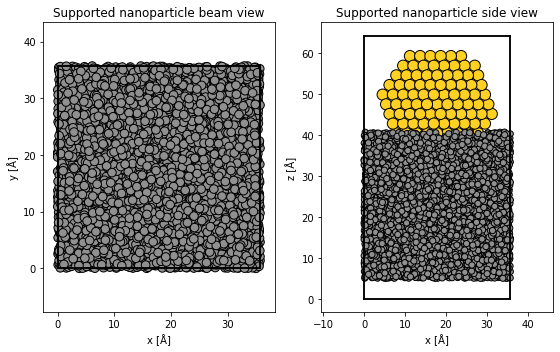

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
abtem.show_atoms(
    supported_nanoparticle,
    ax=ax1,
    title="Supported nanoparticle beam view",
    merge=0.5,
    scale=1,
)
abtem.show_atoms(
    supported_nanoparticle,
    ax=ax2,
    plane="xz",
    scale=1,
    title="Supported nanoparticle side view",
    merge=0.5,
)
fig.tight_layout();

(tutorials:advanced_atomic_models:orthogonal)=
## Orthogonal and periodic supercells

The multislice algorithm requires an orthogonal and periodic atomic structure as its input. However, taking any arbitrary structure and making it periodic and orthogonal is not always trivial, and we therefore give an in-depth tutorial on this problem here.

Below we briefly introduce a tool we have created to solve this problem. To demonstrate the tool, we start by creating a graphene structure with the its minimal non-orthogonal unit cell.

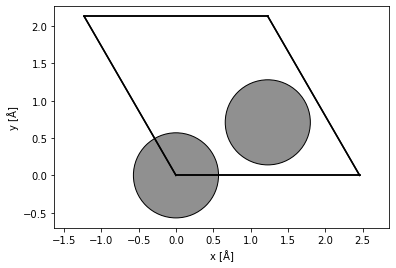

In [14]:
graphene = ase.build.graphene(vacuum=2)

abtem.show_atoms(graphene);

The minimal unit cell of graphene is hexagonal. To make the unit cell orthogonal, we can use abTEM's `orthogonalize_cell` function. 

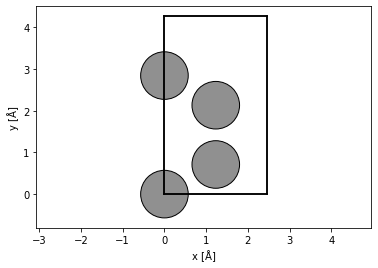

In [15]:
orthogonal_graphene, transform = abtem.orthogonalize_cell(
    graphene, max_repetitions=10, return_transform=True
)

abtem.show_atoms(orthogonal_graphene);

Hexagonal cells can be made orthogonal by doubling the cell size without introducing any strain. However, this is not always possible, which we can realize by returning the transformation required for making the structure orthogonal by setting `return_transform=True`.

Printing this particular transformation, we see that no additional transformation was necessary, as expected.

In [16]:
from abtem.atoms import pretty_print_transform

pretty_print_transform(transform)

Euler angles (degrees): 	 x = 0.000, 	 y = -0.000, 	 z = 0.000
Normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = 0.000
Shear strains (percent): 	 xy = 0.000, 	 xz = 0.000, 	 xz = 0.000


A common, less trivial example is the creation of models with a specific rotation relative to the beam. Here, we want to view FCC gold at a 10&deg; angle.

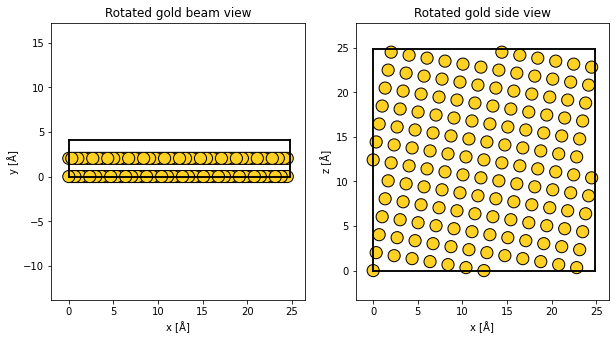

In [17]:
desired_rotation = 10

gold = ase.build.bulk("Au", cubic=True)

gold.rotate(desired_rotation, "y", rotate_cell=True)

gold, transform = abtem.orthogonalize_cell(
    gold, max_repetitions=10, return_transform=True
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

abtem.show_atoms(gold, ax=ax1, scale=0.5, title="Rotated gold beam view")

abtem.show_atoms(gold, ax=ax2, plane="xz", scale=0.5, title="Rotated gold side view");

As shown below, creating the rotated structure required an additional rotation of 0.538&deg;, around the $y$-axis. This means that within the contraint of repeating the structure at most 10 times in either direction (set by the parameter `max_repetitions`), the closest periodic and orthogonal structure is rotated by 10.538&deg; and not the desired 10.0&deg;. This may be close enough, but if not then the number of repetitions can be increased. For example, within `max_repetitions` of 20, the required transform is just -0.008&deg;, around the $y$-axis.

In [18]:
pretty_print_transform(transform)

Euler angles (degrees): 	 x = 0.000, 	 y = 0.538, 	 z = 0.000
Normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = -0.000
Shear strains (percent): 	 xy = 0.000, 	 xz = 0.000, 	 xz = 0.000
